In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [2]:
import importlib
try: 
    importlib.reload(generators)
    importlib.reload(utils)
    importlib.reload(trainers)
    importlib.reload(u_net)
    print("libs reloaded")
except:
    import generators
    import trainers
    import utils
    import u_net
    print("libs imported")

TrainerUNET = trainers.TrainerUNET

libs imported


# UNET

In [3]:
# directorys with data and to store training checkpoints and logs
WORKING_DIR = Path(r"C:\Users\20182371\Documents\TUe\8DM20_CS_Medical_Imaging\DeepLearning_Project")
DATA_DIR = WORKING_DIR / "TrainingData"
PROGRESS_DIR = WORKING_DIR / "progress_unet"
PROGRESS_DIR.mkdir(parents=True, exist_ok=True)
VAEMASK_WEIGHTS = WORKING_DIR / "progress_vaemask" / "200_epochs_16_zdim_final" / "model.pth"
VAEGAN_WEIGHTS = WORKING_DIR / "progress_vaegan" / "200_epochs_256_zdim_final" / "model.pth"

# training settings and hyperparameters
NO_VALIDATION_PATIENTS = 3
IMAGE_SIZE = [64, 64]  # images are made smaller to save training time
N = 15
train_size = N-NO_VALIDATION_PATIENTS
seed = 0
N_EPOCHS = 100
DECAY_LR_AFTER = 50
LEARNING_RATE = 1e-4
TOLERANCE = 0.01  # for early stopping
DISPLAY_FREQ = 5
Number_of_fake  = 0
BATCH_SIZE = 32 - Number_of_fake
BATCH_SIZE_VALID = 32
EARLY_STOPPING = True
MINIMUM_VALID_LOSS = 10
exp = str(N_EPOCHS) + '_epochs_' + str(Number_of_fake) + "_number_of_fake_NAdam_betas_lr_1e-3"
EXPERIMENT_DIR = PROGRESS_DIR / exp
EXPERIMENT_DIR.mkdir(parents=True, exist_ok=True)

utils.remove_empty_masks(DATA_DIR)

patients = [
    path
    for path in DATA_DIR.glob("*")
    if not any(part.startswith(".") for part in path.parts)
]

train_indx, valid_indx = train_test_split(patients, random_state=seed, train_size=train_size)

# split in training/validation after shuffling
partition = {
    "train": train_indx,
    "validation": valid_indx,
}

mask_generator = generators.VAE(spade=False).to(device)
mask_generator.load_state_dict(torch.load(VAEMASK_WEIGHTS))
mask_generator.eval()

image_generator = generators.VAEGAN(spade=True).to(device)
image_generator.load_state_dict(torch.load(VAEGAN_WEIGHTS))
image_generator.eval()

# load training data and create DataLoader with batching and shuffling
train_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE)
train_loader = DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

# load validation data
valid_set = utils.ProstateMRDataset(partition["validation"], IMAGE_SIZE)
valid_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE_VALID,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

mask_set = utils.ProstateMRDataset(partition["train"], IMAGE_SIZE, empty_masks=True)
mask_loader = DataLoader(
    valid_set,
    batch_size=BATCH_SIZE_VALID,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
)

def lambda_lr(the_epoch):
    return (
        1.0
        if the_epoch < DECAY_LR_AFTER
        else 1 - float(the_epoch - DECAY_LR_AFTER) / (N_EPOCHS - DECAY_LR_AFTER)
    )

# initialise model, optimiser, and loss function
unet_model = u_net.UNet(num_classes=1).to(device)
optimizer = torch.optim.NAdam(unet_model.parameters(), lr=LEARNING_RATE, betas=(0.9,0.5)) #betas 0.9, 0 



In [4]:
u_net_trainer = TrainerUNET(net=unet_model, 
                            optimizer=optimizer, 
                            progress_dir=EXPERIMENT_DIR, 
                            train_loader=train_loader, 
                            valid_loader=valid_loader, 
                            mask_loader=mask_loader,
                            mask_generator=mask_generator,
                            image_generator=image_generator,
                            TOLERANCE = TOLERANCE,
                            minimum_valid_loss = MINIMUM_VALID_LOSS,
                            Number_of_fake = Number_of_fake,
                            CHECKPOINTS_DIR=EXPERIMENT_DIR, 
                            device=device,
                            early_stopping=EARLY_STOPPING) 

In [5]:
u_net_trainer.train(N_EPOCHS, 1, lambda_lr=lambda_lr)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #000: DiceBCELoss/train = 1.055 | DiceBCELoss/valid = 1.063


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #001: DiceBCELoss/train = 0.803 | DiceBCELoss/valid = 0.960


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #002: DiceBCELoss/train = 0.613 | DiceBCELoss/valid = 0.741


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #003: DiceBCELoss/train = 0.468 | DiceBCELoss/valid = 0.705


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #004: DiceBCELoss/train = 0.361 | DiceBCELoss/valid = 0.862


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #005: DiceBCELoss/train = 0.321 | DiceBCELoss/valid = 0.865


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #006: DiceBCELoss/train = 0.268 | DiceBCELoss/valid = 0.845


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #007: DiceBCELoss/train = 0.243 | DiceBCELoss/valid = 0.683


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #008: DiceBCELoss/train = 0.214 | DiceBCELoss/valid = 0.529


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #009: DiceBCELoss/train = 0.184 | DiceBCELoss/valid = 0.517


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #010: DiceBCELoss/train = 0.166 | DiceBCELoss/valid = 0.507


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #011: DiceBCELoss/train = 0.146 | DiceBCELoss/valid = 0.508


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #012: DiceBCELoss/train = 0.142 | DiceBCELoss/valid = 0.439


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #013: DiceBCELoss/train = 0.156 | DiceBCELoss/valid = 0.489


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #014: DiceBCELoss/train = 0.129 | DiceBCELoss/valid = 0.469


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #015: DiceBCELoss/train = 0.117 | DiceBCELoss/valid = 0.448


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #016: DiceBCELoss/train = 0.111 | DiceBCELoss/valid = 0.479


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #017: DiceBCELoss/train = 0.100 | DiceBCELoss/valid = 0.481


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #018: DiceBCELoss/train = 0.097 | DiceBCELoss/valid = 0.471


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #019: DiceBCELoss/train = 0.092 | DiceBCELoss/valid = 0.462


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #020: DiceBCELoss/train = 0.084 | DiceBCELoss/valid = 0.519


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #021: DiceBCELoss/train = 0.083 | DiceBCELoss/valid = 0.559


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #022: DiceBCELoss/train = 0.079 | DiceBCELoss/valid = 0.460


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #023: DiceBCELoss/train = 0.078 | DiceBCELoss/valid = 0.475


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #024: DiceBCELoss/train = 0.075 | DiceBCELoss/valid = 0.526


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch #025: DiceBCELoss/train = 0.072 | DiceBCELoss/valid = 0.547


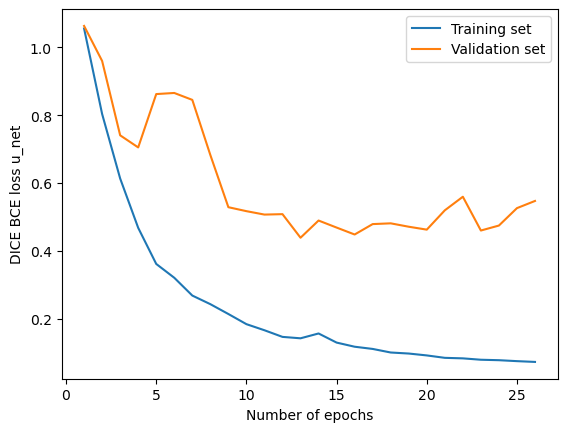

In [6]:
plt.plot(range(1, len(u_net_trainer.train_losses[0])+1), u_net_trainer.train_losses[0])
plt.plot(range(1, len(u_net_trainer.train_losses[0])+1), u_net_trainer.valid_losses[0])
plt.xlabel('Number of epochs')
plt.ylabel('DICE BCE loss u_net')
plt.legend(['Training set', 'Validation set'])
plot_name = 'DICE_BCE_LOSS_'+ str(N_EPOCHS) + '_epochs_' + str(Number_of_fake) + "_number_of_fake.png"
path = EXPERIMENT_DIR / plot_name

plt.savefig(path, dpi=200)